Description: Detect edge & evaluate FOM of proposed method with various noise level

Python version: 3.9

In [5]:
# Link Google colab notebook to your personal google drive account.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Install ruptures package (colab ver.)
!pip install ruptures
!pip install skan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 29.4 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 3.2 MB 66.6 MB/s 
     |████████████████████████████████| 100 kB 12.4 MB/s 
     |████████████████████████████████| 90 kB 11.4 MB/s 
     |████████████████████████████████| 1.1 MB 85.9 MB/s 
     |████████████████████████████████| 121 kB 99.3 MB/s 
     |████████████████████████████████| 84 kB 4.6 MB/s 
     |████████████████████████████████| 133 kB 72.9 MB/s 
  Attempting uninstall: Pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfu

In [7]:
# %% Import libraries
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io  # v.0.18.1
from skimage import filters
from skimage.morphology import disk
from pathlib import Path
from os import sep
from cv2 import morphologyEx, MORPH_OPEN
import sys

In [8]:
# Import original module
project_path = f"{sep}content{sep}drive{sep}My Drive{sep}my_project{sep}"
sys.path.append(project_path)

from cpseg_module.cpseg_functions_colab import ak_rotate_edge_overlay, postprocessing

In [9]:
# Input image file names in /content/drive/my_project
imFile = "4_DualSideFusion_crop_1_f001z01_C0.tif"  # Original image file

In [10]:
# %% Parameters
# Image file
rootfile = f"{sep}content{sep}drive{sep}My Drive{sep}my_project{sep}"
# Get image file name
imFilename = f"{rootfile}{imFile}"              # Image file path                                    
se_size = 200                                   # Background subtraction
medianValue = [5, 5]#[30, 30]                   # Median filter
y_interval = 2  # 5                             # Sparse scan along y-axis, pixel
rotation_angle = 4 #3                           # 0: 45 degree, 3: semicircle
                                                # 1: 30 degree, 4: semicircle
                                                # 2: 15 degree, 5: semicircle
changepoint_algo = 1                            # 0: number known, 1: number not known
numBorder = 4                                   # Number of change points,
                                                # if changepoint_algo = 1, use PELT for panelized detection
penalty_value = 100000                          # Penalty cost when numBorder = 0
numlayer = 1                                    # 0: single <- avoid in this workflow
                                                # 1: overlay multiple
model = "linear"                                # "rbf", "linear", "cosine"
#postprocess = 1                                 # 0: no, 1:yes
smallNoiseRemov = 1                             # 0:No noise removal
                                                # 1:Connect border, then remove small noises
                                                # 2:Remove small noisess first, then connect
senoise = y_interval * 2                        # Structural element size of morphology opening:default:5
neib = 25                                       # Remove small objects less than neib(pixel) default:100
select_biggest = 0                              # 0: No selection; 1: select biggest
nskeletonize = 1                                # 0: No skeletonization, 1: with skeletonization

In [11]:
# %% Processing
# Set result containers
nImFile = np.size(imFilename)
# Detect borders using the proposed method
I0 = io.imread(imFilename)
I0 = np.array(I0)
BW_final = np.zeros(I0.shape)  # empty border object
Iori = io.imread(imFilename)  # Load image
Iori = np.array(Iori)

# Pre-processing
se_imopen = disk(se_size)                                   # structrul element for morph open
background = morphologyEx(Iori, MORPH_OPEN, se_imopen)    # opening
I_bg = Iori - background                                  # Subtract background
Ien = filters.median(I_bg, disk(medianValue[0]))          # Smoothing filter, footprint=disk(medianValue[0])
# Edge detection w/ proposed method
# Rotate & detect edge
BW = ak_rotate_edge_overlay\
    (Ien,numlayer,rotation_angle,numBorder,model,y_interval,penalty_value, changepoint_algo)
print('Edge detected.')

# Post-processing
BWlast = postprocessing(BW)

Edge detected.


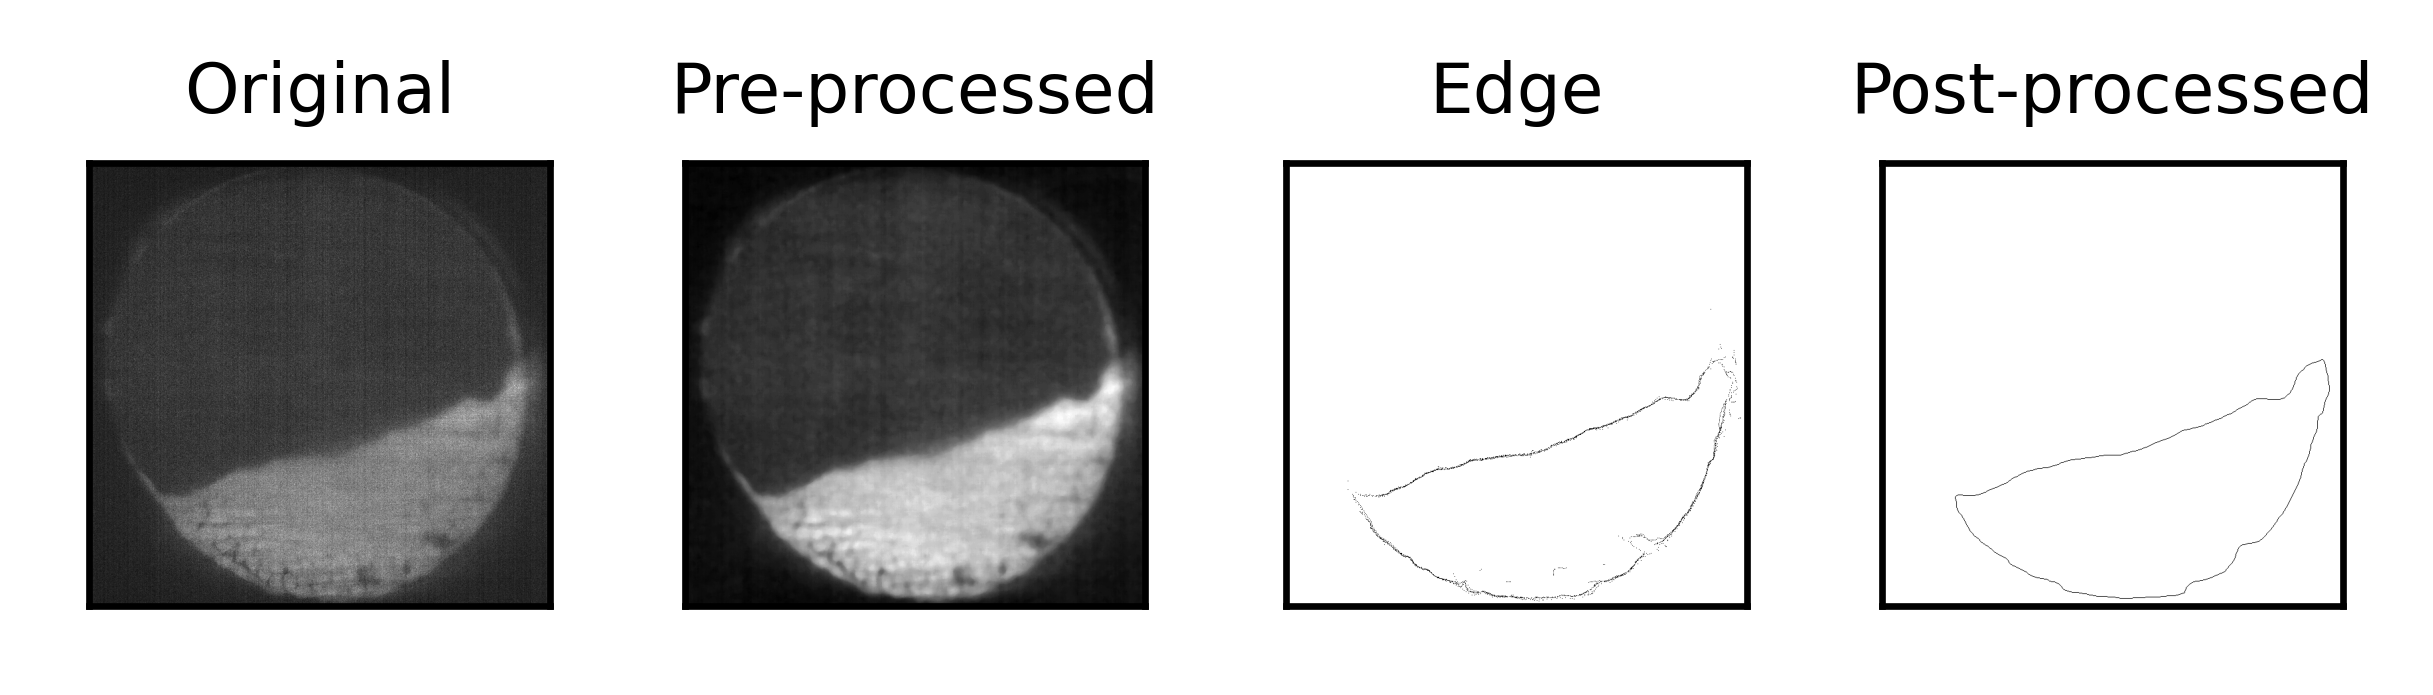

In [13]:
# Show results
fig, ax = plt.subplots(1,4, constrained_layout = True, figsize=(4, 1), dpi=600) # figsize: figure dimension (width, height) in inches.
ax[0].imshow(Iori, cmap='gray')
ax[0].set_title('Original',fontsize='small')
ax[1].imshow(Ien, cmap='gray')
ax[1].set_title('Pre-processed',fontsize='small')
ax[2].imshow(BW, cmap='gray_r')
ax[2].set_title('Edge',fontsize='small')
ax[3].imshow(BWlast, cmap='gray_r')
ax[3].set_title('Post-processed',fontsize='small')

for i in np.arange(0,4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

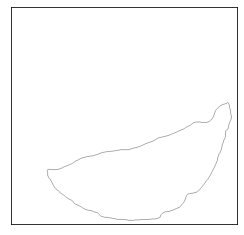

In [16]:
# Save edge
fig2, ax2 = plt.subplots()
ax2.imshow(BWlast,cmap='gray_r')
ax2.set_xticks([])
ax2.set_yticks([])
plt.ioff()
result_path = f"{project_path}result{sep}"
save_file = f"{result_path}edge.png"
plt.savefig(save_file, dpi=600)